# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [5]:
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/music_dataset.csv
!wget https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/tracks_info.csv 

--2023-06-10 14:43:45--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/music_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1321738 (1.3M) [text/plain]
Saving to: ‘music_dataset.csv’

music_dataset.csv   100%[===================>]   1.26M  --.-KB/s    in 0.04s   

2023-06-10 14:43:45 (32.5 MB/s) - ‘music_dataset.csv’ saved [1321738/1321738]

--2023-06-10 14:43:45--  https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw4/tracks_info.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 2

In [6]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [7]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [8]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [9]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):

    def apk(actual, predicted, k):
        if not actual:
            return 0

        if len(predicted) > k:
            predicted = predicted[:k]

        score = 0
        num_hits = 0

        for i, p in enumerate(predicted):
            if p in actual and p not in predicted[:i]:
                num_hits += 1
                score += num_hits / (i + 1)

        return score / min(len(actual), k)

    return np.mean([apk(a,p,k) for a,p in zip(relevant, predicted)])

In [10]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [11]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [12]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [13]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [14]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [15]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [16]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [17]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [18]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [19]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for user in range(self.n_users):
            test_preds.append(self.recommend(user))

        test_preds = self.remove_train_items(test_preds, k)
    
        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [20]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    covariance = ratings @ user_vector
    stdev_u = np.sqrt(user_vector @ user_vector)
    stdev_r = np.sqrt(ratings.sum(axis=1))

    return covariance / (stdev_u * stdev_r)


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = ratings @ user_vector
    union = np.sum(user_vector > 0) + np.sum(ratings > 0, axis=1) - intersection

    return intersection / union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [21]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R[uid, :]
        similarities = self.similarity(user_vector)

        items_users = np.where((similarities > self.alpha) & (similarities < 1))[0]
        user_recommend = similarities[items_users] @ self.R[items_users, :]
        
        return np.argsort(-user_recommend)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [23]:
p_mapk, j_mapk, r_mapk = [], [], []

k_val = range(1, 50+1)

p_recs = User2User(train_ratings, pearson).get_test_recommendations(len(k_val))
j_recs = User2User(train_ratings, jaccard).get_test_recommendations(len(k_val))

r_recs = [list(np.random.randint(0, ratings["trackId"].max(), len(k_val))) for _ in k_val]

for k in k_val:
    p_mapk.append(mapk(test_relevant, p_recs, k))
    j_mapk.append(mapk(test_relevant, j_recs, k))
    r_mapk.append(mapk(test_relevant, r_recs, k))

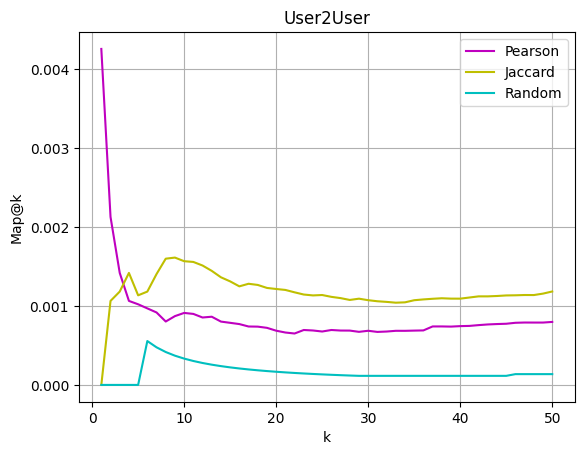

In [24]:
plt.plot(k_val, p_mapk, label='Pearson', c='m')
plt.plot(k_val, j_mapk, label='Jaccard', c='y')
plt.plot(k_val, r_mapk, label='Random', c='c')

plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.title('User2User')
plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [25]:
from scipy import sparse

class BaseModel2(BaseModel):
    def __init__(self, ratings: pd.DataFrame):
        super().__init__(ratings)
        self.R = sparse.csr_matrix(self.R)

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id].reshape(-1, 1)
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k].reshape(1, -1)

        return new_preds


class User2User2(BaseModel2):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson2, jaccard2]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R[uid, :]
        similarities = self.similarity(user_vector)

        items_users = np.where((similarities > self.alpha) & (similarities < 1))[0]
        user_recommend = similarities[items_users].squeeze() @ self.R[items_users, :]
        
        return np.argsort(-user_recommend).squeeze()

In [26]:
def pearson2(ratings: np.array, user_vector: np.array) -> np.array:
    user_vector = user_vector.toarray()
    covariance = ratings @ user_vector.T
    stdev_u = np.sqrt(user_vector.sum())
    stdev_r = np.sqrt(ratings.sum(axis=1))

    return covariance / (stdev_u * stdev_r)


def jaccard2(ratings: np.array, user_vector: np.array) -> np.array:
    user_vector = user_vector.reshape(1, -1)
    ru_rv_common =  np.sum(ratings * user_vector.reshape(-1, 1), axis = 1)
    
    user_matrix = sparse.csr_matrix(np.ones((ratings.shape[0], 1))) * user_vector
    
    ru_rv_all = ratings + user_matrix
    ru_rv_all = ru_rv_all.sum(axis = 1) - ru_rv_common

    return ru_rv_common / ru_rv_all

In [27]:
p2_mapk, j2_mapk, r2_mapk = [], [], []

p2_recs = User2User2(train_ratings, pearson2).get_test_recommendations(len(k_val))
j2_recs = User2User2(train_ratings, jaccard2).get_test_recommendations(len(k_val))

assert (p2_recs == p_recs).all()
assert (j2_recs == j_recs).all()

for k in k_val:
    p2_mapk.append(mapk(test_relevant, p2_recs, k))
    j2_mapk.append(mapk(test_relevant, j2_recs, k))

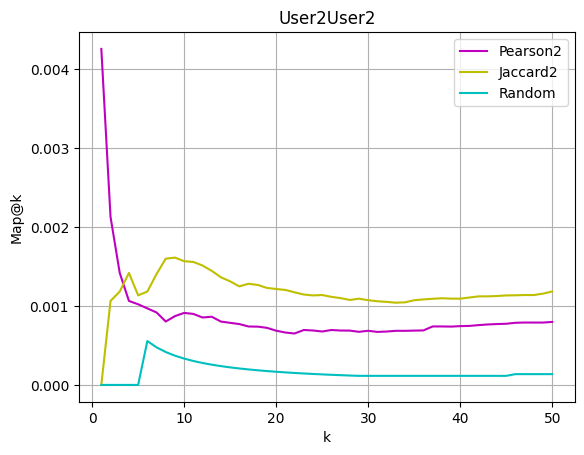

In [28]:
plt.plot(k_val, p2_mapk, label='Pearson2', c='m')
plt.plot(k_val, j2_mapk, label='Jaccard2', c='y')
plt.plot(k_val, r_mapk, label='Random', c='c')

plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.title('User2User2')
plt.show()

In [29]:
from time import time 

t0 = time()
User2User(train_ratings, pearson).get_test_recommendations(len(k_val))
t1 = time()
User2User2(train_ratings, pearson2).get_test_recommendations(len(k_val))
print('time pearson', round(t1 - t0, 2), 'time pearson2', round(time() - t1, 2))

t0 = time()
User2User(train_ratings, jaccard).get_test_recommendations(len(k_val))
t1 = time()
User2User2(train_ratings, jaccard2).get_test_recommendations(len(k_val))
print('time jaccard', round(t1 - t0, 2), 'time jaccard2', round(time() - t1, 2))

time pearson 11.73 time pearson2 2.93
time jaccard 14.43 time jaccard2 4.98


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [30]:
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(0)

In [31]:
model = User2User2(train_ratings, pearson2)

In [32]:
user_id = np.random.randint(0, model.n_users)

In [33]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
152,Hollywood Whore,['Papa Roach']
164,My Favourite Game,['The Cardigans']
199,Don't Phunk With My Heart,['Black Eyed Peas']
212,Let's Get It Started,['Black Eyed Peas']
234,Wind Of Change,['Scorpions']
344,Somebody Told Me,['The Killers']
396,The Phantom Of The Opera,"['Nightwish', 'Andrew Lloyd Webber']"
422,Stan,"['Eminem', 'Dido']"
464,Tainted Love,['Marilyn Manson']
630,Every Breath You Take,['The Police']


In [34]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
805,Zombie,['The Cranberries']
2814,Numb,['Linkin Park']
8263,Shape Of My Heart,['Sting']
11493,The Show Must Go On,['Queen']
24500,Way Down We Go,['KALEO']
1073,Smells Like Teen Spirit,['Nirvana']
29105,Human,"[""Rag'n'Bone Man""]"
2555,Californication,['Red Hot Chili Peppers']
1286,One Of Us,['Joan Osborne']
6448,Sweet Dreams (Are Made of This),"['Eurythmics', 'Annie Lennox', 'Dave Stewart']"


In [35]:
model = User2User2(train_ratings, jaccard2)

preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
44188,Мокрые кроссы,['Тима Белорусских']
11493,The Show Must Go On,['Queen']
5810,Так же как все,"[""A'Studio""]"
34418,Драмы больше нет,['Полина Гагарина']
4765,Last Night,"['P. Diddy', 'Keyshia Cole']"
39455,Drunk Groove,"['MARUV', 'Boosin']"
46279,"Мама, я танцую",['#2Маши']
49023,Грустный дэнс,"['Artik & Asti', 'Артём Качер']"
39104,Him & I,"['G-Eazy', 'Halsey']"
34834,Tell Me Who,"['Vanotek', 'Eneli']"


In [36]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
63988,If You Love Me,"['Мари Краймбрери', 'Alex Davia']"
64325,Кхуям,['Хитобои']
64568,таблетки,['Земфира']
64574,жди меня,['Земфира']
64576,крым,['Земфира']
64675,ZITTI E BUONI,['Måneskin']
64682,CORALINE,['Måneskin']
64683,I WANNA BE YOUR SLAVE,['Måneskin']
64743,Dernière Danse,"['Yves V', 'Shanguy', 'Axel Cooper']"
65142,Я никогда не стану феминисткой,['Nodahsa']


Предсказанные треки выглядят логичнее Test-time tracks. Но, если все же говорить о схожести с ответами, то да, по Жаккарду рекомендации получаются более схожими.

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Ответ
$$\frac{\partial{L}}{\partial{p_u}} = 2\sum_i{(p_u^Tq_i^2 - r_{ui}q_i)} + 2\lambda \cdot p_u$$

$$\frac{\partial{L}}{\partial{q_i}} = 2\sum_i{(q_i^Tp_u^2 - r_{ui}p_u)} + 2\lambda \cdot q_i$$

$\eta$ - step lr

$$ p'_u = p_u - 2\cdot \eta \cdot (q_i(p_u^Tq_i - r_{ui}) + \lambda \cdot p_u)$$
$$ q'_i = q_i - 2 \cdot \eta \cdot (p_u(q_i^Tp_u - r_{ui}) + \lambda \cdot q_i)$$


\\
**ALS:**

Ответ

Для $P$
$$\frac{\partial{L}}{\partial{p_u}} = -2\sum_i{(r_{ui}-p_u^T \cdot q_i) \cdot q_i^T + 2\lambda p_u^T}$$

$$0 = -(r_u - p_u^T Q^T)\cdot Q + \lambda p_u^T$$

$$p_u^T(Q^TQ + \lambda I) = r_u \cdot Q$$

\\

$$p_u =  r_u \cdot Q(Q^TQ + \lambda I)^{-1}$$

\\

Для $Q$
$$\frac{\partial{L}}{\partial{q_i}} = -2\sum_i{(r_{ui}-q_i^T \cdot p_u) \cdot p_u^T + 2\lambda q_i^T}$$

$$0 = -(r_i - y_i^T P^T)\cdot P + \lambda q_i^T$$

$$q_i^T(P^TP + \lambda I) = r_i \cdot P$$

\\

$$q_i =  r_i \cdot P(P^TP + \lambda I)^{-1}$$




**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [53]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lamb=0.01, lr = 0.0003):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = lr
        self.lamb = lamb

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                user = np.random.randint(self.n_users)
                p = self.P[user, :]

                item = np.random.randint(self.n_items)
                q = self.Q[item, :]

                self.P[user, :] = p - 2 * self.lr * (p @ q * q - self.R[user][item] * q + self.lamb * p)
                self.Q[item, :] = q - 2 * self.lr * (p @ q * p - self.R[user][item] * p + self.lamb * q)
            
            elif self.mode == 'als':
                P_new = np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.dim))
                Q_new = np.linalg.inv(self.P.T @ self.P + np.eye(self.dim) * self.lamb)
                
                rq = self.R @ self.Q
                rp = self.R.T @ self.P

                self.P = rq @ P_new
                self.Q = rp @ Q_new

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [38]:
sgd_mapk, als_mapk = [], []

sgd_recs = HiddenVars(train_ratings, mode='sgd').get_test_recommendations(len(k_val))
als_recs = HiddenVars(train_ratings, mode='als').get_test_recommendations(len(k_val))

for k in k_val:
    sgd_mapk.append(mapk(test_relevant, sgd_recs, k))
    als_mapk.append(mapk(test_relevant, als_recs, k))

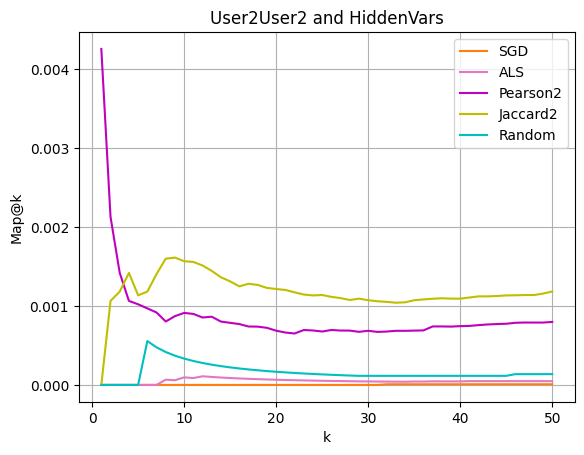

In [39]:
plt.plot(k_val, sgd_mapk, label='SGD', c='tab:orange')
plt.plot(k_val, als_mapk, label='ALS', c='tab:pink')
plt.plot(k_val, p2_mapk, label='Pearson2', c='m')
plt.plot(k_val, j2_mapk, label='Jaccard2', c='y')
plt.plot(k_val, r_mapk, label='Random', c='c')

plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.title('User2User2 and HiddenVars')
plt.show()

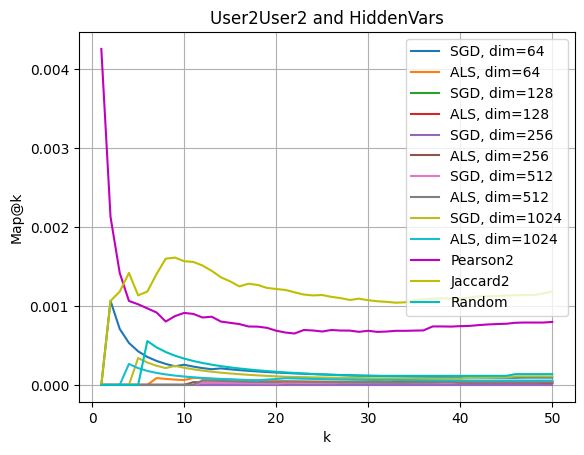

In [40]:
for d in [64, 128, 256, 512, 1024]:
    sgd_mapk, als_mapk = [], []

    sgd_recs = HiddenVars(train_ratings, mode='sgd', dim=d).get_test_recommendations(len(k_val))
    als_recs = HiddenVars(train_ratings, mode='als', dim=d).get_test_recommendations(len(k_val))

    for k in k_val:
        sgd_mapk.append(mapk(test_relevant, sgd_recs, k))
        als_mapk.append(mapk(test_relevant, als_recs, k))

    plt.plot(k_val, sgd_mapk, label=f'SGD, dim={d}')
    plt.plot(k_val, als_mapk, label=f'ALS, dim={d}')

plt.plot(k_val, p2_mapk, label='Pearson2', c='m')
plt.plot(k_val, j2_mapk, label='Jaccard2', c='y')
plt.plot(k_val, r_mapk, label='Random', c='c')

plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.title('User2User2 and HiddenVars')
plt.show()

Не удается подобрать оптимальную размерность скрытого простравства. Качество моделей хуже рандомной.

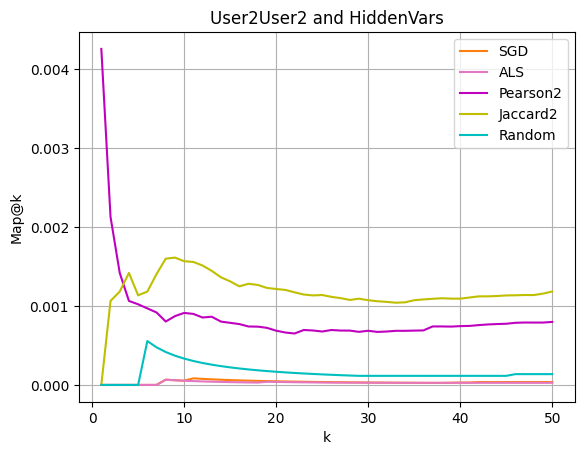

In [41]:
sgd_mapk, als_mapk = [], []

sgd_recs = HiddenVars(train_ratings, mode='sgd', dim=5000).get_test_recommendations(len(k_val))
als_recs = HiddenVars(train_ratings, mode='als').get_test_recommendations(len(k_val))

for k in k_val:
    sgd_mapk.append(mapk(test_relevant, sgd_recs, k))
    als_mapk.append(mapk(test_relevant, als_recs, k))

plt.plot(k_val, sgd_mapk, label='SGD', c='tab:orange')
plt.plot(k_val, als_mapk, label='ALS', c='tab:pink')
plt.plot(k_val, p2_mapk, label='Pearson2', c='m')
plt.plot(k_val, j2_mapk, label='Jaccard2', c='y')
plt.plot(k_val, r_mapk, label='Random', c='c')

plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.title('User2User2 and HiddenVars')
plt.show()

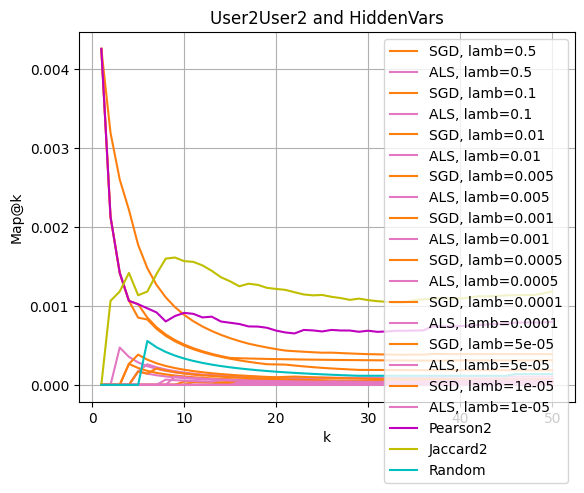

In [42]:
for lamb in [0.5, 0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-5, 1e-5]:
    sgd_mapk, als_mapk = [], []

    sgd_recs = HiddenVars(train_ratings, mode='sgd', lamb=lamb).get_test_recommendations(len(k_val))
    als_recs = HiddenVars(train_ratings, mode='als', lamb=lamb).get_test_recommendations(len(k_val))

    for k in k_val:
        sgd_mapk.append(mapk(test_relevant, sgd_recs, k))
        als_mapk.append(mapk(test_relevant, als_recs, k))
        
    plt.plot(k_val, sgd_mapk, label=f'SGD, lamb={lamb}', c='tab:orange')
    plt.plot(k_val, als_mapk, label=f'ALS, lamb={lamb}', c='tab:pink')

plt.plot(k_val, p2_mapk, label='Pearson2', c='m')
plt.plot(k_val, j2_mapk, label='Jaccard2', c='y')
plt.plot(k_val, r_mapk, label='Random', c='c')

plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.title('User2User2 and HiddenVars')
plt.show()

Лямбду подобрать не удалось, все плохо.
Воспользуемся оптимайзером

In [43]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00


In [58]:
import optuna
from IPython.core.display import clear_output

def train_and_test(mode):
    def test_best(trial):
        if mode == 'sgd':
            params = {'mode': mode,
                    'dim': trial.suggest_int('dim', 64, 2048),
                    'lamb': trial.suggest_float('lamb', 1e-5, 1e-3),
                    'lr': trial.suggest_float('lr', 1e-8, 1e-3),
                    }

            model = HiddenVars(train_ratings, **params)
            model.fit(trial.suggest_int('iters', 50, 500, 25))
          
        else:
            params = {'mode': mode,
                      'dim': trial.suggest_int('dim', 128, 2048),
                      'lamb': trial.suggest_float('lamb', 1e-5, 1e-1),
                    }

            model = HiddenVars(train_ratings, **params)
            model.fit(trial.suggest_int('iters', 10, 50))

        
        result = model.get_test_recommendations(50)
        best_mapk = 0

        for k in range(1, 51):
            cur_mapk = mapk(test_relevant, result, k)
            if cur_mapk > best_mapk:
                best_mapk = cur_mapk

        clear_output()
        return best_mapk

    return test_best

In [59]:
optimazer = optuna.create_study(direction='maximize')
optimazer.optimize(train_and_test('sgd'), n_trials=25)
optimazer.best_params

[I 2023-06-10 17:48:31,587] Trial 24 finished with value: 0.0006205673758865247 and parameters: {'dim': 239, 'lamb': 0.0009970628644662034, 'lr': 0.00019977870667533322, 'iters': 250}. Best is trial 5 with value: 0.00851063829787234.


{'dim': 1108,
 'lamb': 0.0009513179327133553,
 'lr': 0.00014289673666425243,
 'iters': 300}

In [60]:
optimazer.best_value

0.00851063829787234

In [295]:
optimazer = optuna.create_study(direction='maximize')
optimazer.optimize(train_and_test('als'), n_trials=25)
optimazer.best_params

[I 2023-06-10 14:23:11,995] Trial 24 finished with value: 0.00851063829787234 and parameters: {'dim': 885, 'lamb': 0.03182814262470434, 'iters': 30}. Best is trial 3 with value: 0.01276595744680851.


{'dim': 322, 'lamb': 0.04663865473607887, 'iters': 10}

In [296]:
optimazer.best_value

0.01276595744680851

In [97]:
sgd_m = HiddenVars(train_ratings, mode='sgd', dim=1108, lamb=0.00095, lr=0.000143)
sgd_m.fit(num_iters=300)

als_m = HiddenVars(train_ratings, mode='als', dim=322, lamb=0.0466)
als_m.fit(num_iters=10)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

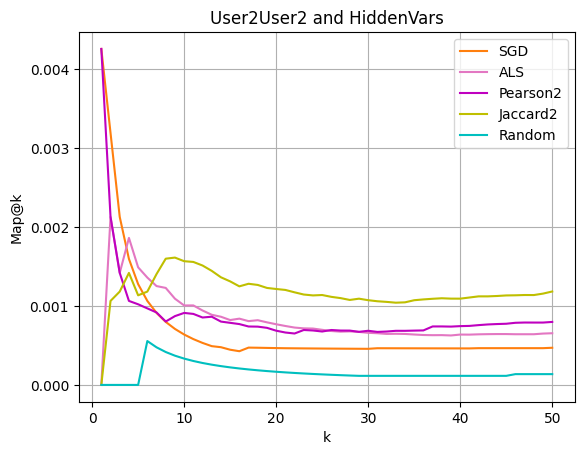

In [98]:
sgd_recs = sgd_m.get_test_recommendations(len(k_val))
als_recs = als_m.get_test_recommendations(len(k_val))

sgd_mapk, als_mapk = [], []
for k in k_val:
    sgd_mapk.append(mapk(test_relevant, sgd_recs, k))
    als_mapk.append(mapk(test_relevant, als_recs, k))
        
plt.plot(k_val, sgd_mapk, label='SGD', c='tab:orange')
plt.plot(k_val, als_mapk, label='ALS', c='tab:pink')

plt.plot(k_val, p2_mapk, label='Pearson2', c='m')
plt.plot(k_val, j2_mapk, label='Jaccard2', c='y')
plt.plot(k_val, r_mapk, label='Random', c='c')

plt.ylabel('Map@k')
plt.xlabel('k')
plt.legend()
plt.grid()
plt.title('User2User2 and HiddenVars')
plt.show()

Модели со скрытыми переменными хороши на небольшом кол-ве k (до 7), дальше все таки выигрывает User2User c Жаккардом. Качество SGD близко к рандому. ALS выдает схожие рекомендации с Пирсоном.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [182]:
model = sgd_m

example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [183]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
54168,Let's Face The Music And Dance,['Jeff Goldblum & the Mildred Snitzer Orchestr...,0.149993
43705,Выходи из воды сухим,['DAKOOKA'],0.125225
35803,Вылечусь,['Бьянка'],0.117469
50744,Девочка в классе,['Джизус'],0.116386
41594,Динамики 3.0,['Свобоda'],0.115884
17890,IN THE MOOD (from Sun Valley Serenade),['Glenn Miller'],0.115595
49668,Insomnia,['Daya'],0.115154
64490,test drive,['Ariana Grande'],0.110326
17682,Midnight City,['M83'],0.108014


In [186]:
model = sgd_m

example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [187]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
54168,Let's Face The Music And Dance,['Jeff Goldblum & the Mildred Snitzer Orchestr...,0.149993
43705,Выходи из воды сухим,['DAKOOKA'],0.125225
35803,Вылечусь,['Бьянка'],0.117469
50744,Девочка в классе,['Джизус'],0.116386
41594,Динамики 3.0,['Свобоda'],0.115884
17890,IN THE MOOD (from Sun Valley Serenade),['Glenn Miller'],0.115595
49668,Insomnia,['Daya'],0.115154
64490,test drive,['Ariana Grande'],0.110326
17682,Midnight City,['M83'],0.108014


In [184]:
model = als_m

example_trackId = tracks_info[tracks_info.name == 'Happy Nation'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [185]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
11139,Happy Nation,['Ace of Base'],1.000000
3825,It Must Have Been Love,['Roxette'],0.772747
7591,Insatiable,['Darren Hayes'],0.772579
6980,Cheri Cheri Lady,['Modern Talking'],0.748814
6179,My All,['Mariah Carey'],0.747295
11136,Beautiful Life,['Ace of Base'],0.747249
26983,Broken Angel,"['Arash', 'Helena']",0.733208
6979,"You're My Heart, You're My Soul",['Modern Talking'],0.728051
11042,One And One,['Robert Miles'],0.725451
47298,Adelante,['Sash!'],0.722048


## Классные рекомендации, лучше спотифая.